# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
import os
os.chdir("C:/Users/USER/Documents/Python/_AD_Python_part_1_Lectures/AD_Python_1_12_GBM/")


Задача. Нужно научиться распознавать доход человека (больше $50000 в год или меньше) по его ответам в ходе переписи населения.
Данные
https://archive.ics.uci.edu/ml/datasets/Adult

Описание данных:
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [3]:

# Имена переменных
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Читаем и обрабатываем обучающую выборку
df = pd.read_csv('adult.data', header=None, names=columns, na_values=' ?')
# Удаляем колонку education (потому что есть уже закодированная колонка education-num)
df = df.drop('education', axis=1)
# Кодируем отклик значениями 0 и 1
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
# удаляем строки с NA значениями
df = df.dropna()

# Читаем и обрабатываем тестовую выборку, как выше
test = pd.read_csv('adult.test', header=None, names=columns, na_values=' ?', skiprows=1)
test = test.drop('education', axis=1)
test['income'] = test['income'].map({' <=50K.': 0, ' >50K.': 1})
test = test.dropna()

In [4]:
# Все хорошо?
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Классы сбалансированы? Посчитаем распределение наблюдений по классам.

In [5]:
df['income'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income, dtype: float64

Разбивать данные на обучающее и тестовое множество не надо. 
Уже сделано: таблицы df и test. 
Бинаризуем признаки, измеренные в номинальной шкале (категориальные признаки).
В Python эта операция часто называется one-hot encoding.

In [6]:
X_train = pd.get_dummies(df).drop('income', axis=1)
y_train = df['income']

X_test = pd.get_dummies(test).drop('income', axis=1)
y_test = test['income']

In [7]:
#   После бинаризации смотрим на получившиеся переменные
#   X_test.columns

После бинаризации категориальных признаков оказывается, что в обучающем множестве содержится на один столбец больше. 

In [8]:
print (len(X_train.columns))
print (len(X_test.columns))


88
87


Оказывается, в тестовой выборке нет ни одного представителя Голландии 
в колонке ```native-county```.

In [9]:
# Приводим множество названий колонок к типу set, находим разность двух множеств.
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

{'native-country_ Holand-Netherlands'}
set()


Исправляем. 
Создадим полный список всех колонок (из обучающего и тестового множеств) и переиндексируем колонки в соответствии с этим списком. В результате в колонке ```native-country_ Holand-Netherlands``` в тестовом множестве появятся NaN-значения, которые мы заменим на нули.

In [10]:
columns = set(X_train.columns) | set(X_test.columns)
X_train = X_train.reindex(columns=columns).fillna(0)
X_test = X_test.reindex(columns=columns).fillna(0)


Теперь наборы колонок в обучающем и тестовом множествах идентичны. 
Порядок колонок тоже совпадает. 
На всякий случай убедимся в этом. 

In [11]:
# Команда all проверяет, все ли значения из входного списка равны True
all(X_train.columns == X_test.columns)

True

Перейдём к созданию модели.
Хотя можно (нужно!) многое улучшить.
Например, объединить некоторые колонки, где мало "1".

#  XGBoost

In [12]:
# conda install py-xgboost
# conda install -c anaconda py-xgboost  -- появилась Teano
from xgboost import XGBClassifier

# from sklearn.metrics import classification_report

from sklearn import metrics

In [13]:
model = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print (metrics.classification_report(y_train, y_pred_train))

y_pred_test = model.predict(X_test)
print (metrics.classification_report(y_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.91      0.96      0.93     22654
          1       0.84      0.73      0.78      7508

avg / total       0.90      0.90      0.90     30162

             precision    recall  f1-score   support

          0       0.90      0.94      0.92     11360
          1       0.77      0.66      0.71      3700

avg / total       0.87      0.87      0.87     15060



C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [15]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,21642,1012
1,2061,5447


In [16]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,10632,728
1,1247,2453


In [17]:
print("Accuracy on train set is ", metrics.accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", metrics.accuracy_score(y_test, y_pred_test)*100)

Accuracy on train set is  89.81168357535972
Accuracy on test set is  86.88579017264276


In [18]:
import seaborn as sns
sns.set(font_scale = 1.5)

In [19]:
import xgboost as xgb


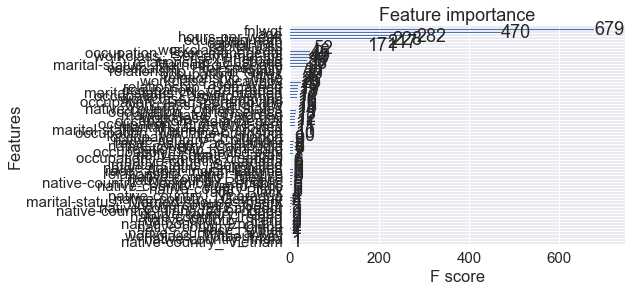

In [20]:
xgb.plot_importance(model)

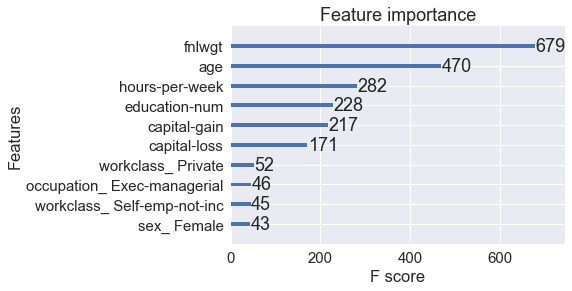

In [21]:
xgb.plot_importance(model, max_num_features = 10)
#  xgb.plot_importance(model, max_num_features = 20)
#  xgb.plot_importance(model, max_num_features = 30)


In [28]:
#  help(xgb.plot_importance)

In [29]:
### Grid Search  Вариант 1

In [14]:
from sklearn.grid_search import GridSearchCV


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:
#  from sklearn.model_selection import GridSearchCV

In [23]:
#  Если использовать параметры по умолчанию 
#  Так делали выше
#  model = XGBClassifier(seed=42,
#                        n_estimators=100,
#                        max_depth=6,
#                        learning_rate=0.3)

In [ ]:
#  Слишком много перебирать для лекции

#  grid_param = {  
#      'n_estimators': [100, 300, 500, 800, 1000],
#      'max_depth': [3, 4, 6],
#      'learning_rate': [0.05, 0.1, 0.3]
#  }

In [25]:
#  Сокращенный набор комбинация

grid_param = {  
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 4, 6]
}

In [ ]:
#  Сокращенный набор комбинация

grid_param = {  
    'n_estimators': [100, 500, 1000],
}

In [26]:
zzz = GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, seed=1234, 
       objective='binary:logistic',                         
       colsample_bylevel=1, colsample_bytree=0.8, subsample=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, 
       min_child_weight=1, missing=None, nthread=-1,
       reg_alpha=0, reg_lambda=1, 
       scale_pos_weight=1, silent=True),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=grid_param,
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)


In [27]:
zzz.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
       silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000], 'max_depth': [3, 4, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [35]:
#  sorted(zzz.cv_results_.keys())

In [28]:
zzz.grid_scores_

[mean: 0.85939, std: 0.00427, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.86957, std: 0.00353, params: {'max_depth': 3, 'n_estimators': 500},
 mean: 0.86871, std: 0.00335, params: {'max_depth': 3, 'n_estimators': 1000},
 mean: 0.86582, std: 0.00370, params: {'max_depth': 4, 'n_estimators': 100},
 mean: 0.86808, std: 0.00366, params: {'max_depth': 4, 'n_estimators': 500},
 mean: 0.86536, std: 0.00318, params: {'max_depth': 4, 'n_estimators': 1000},
 mean: 0.86848, std: 0.00326, params: {'max_depth': 6, 'n_estimators': 100},
 mean: 0.86330, std: 0.00160, params: {'max_depth': 6, 'n_estimators': 500},
 mean: 0.85919, std: 0.00514, params: {'max_depth': 6, 'n_estimators': 1000}]

In [ ]:
### Grid Search  Вариант 2

Будем перебирать все возможные варианты параметров с поиском

Внимание:  стратифицированное валидационное множество

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier()

# Задаём сетку параметров
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.05, 0.1]
# Задаём словарь с параметрами
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
# Задаём разбиение данных на лёрн и тест n_splits раз. Для каждого такого разбиения буде
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, scoring="f1", cv=kfold, verbose=2, n_jobs=4)
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
grid_result.best_score_

In [ ]:
grid_result.best_params_